In [24]:
# !zip -r faces_dataset.zip /datasets/faces/

In [25]:
# import pandas as pd

# data = pd.read_csv('/datasets/faces/labels.csv>')
# data.to_csv('**labels.csv**', index=False)

## Initialization

In [26]:
import os
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [27]:
# Load labels
labels_path = '/datasets/faces/labels.csv'
labels = pd.read_csv(labels_path)

# Preview the first few rows
print(labels.head())

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


## EDA

In [28]:
image_folder = '/datasets/faces/final_files/'

# Initialize ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,  # Scale pixel values to 0-1
    validation_split=0.25  # Set 25% of data for validation
)

# Create training and validation generators
train_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=image_folder,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    shuffle=True,
    seed=373737
)

val_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=image_folder,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    shuffle=False,
    seed=373737
)

# Print dataset size
print(f"Number of training images: {train_generator.samples}")
print(f"Number of validation images: {val_generator.samples}")

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Number of training images: 5694
Number of validation images: 1897


#### Age Distribution

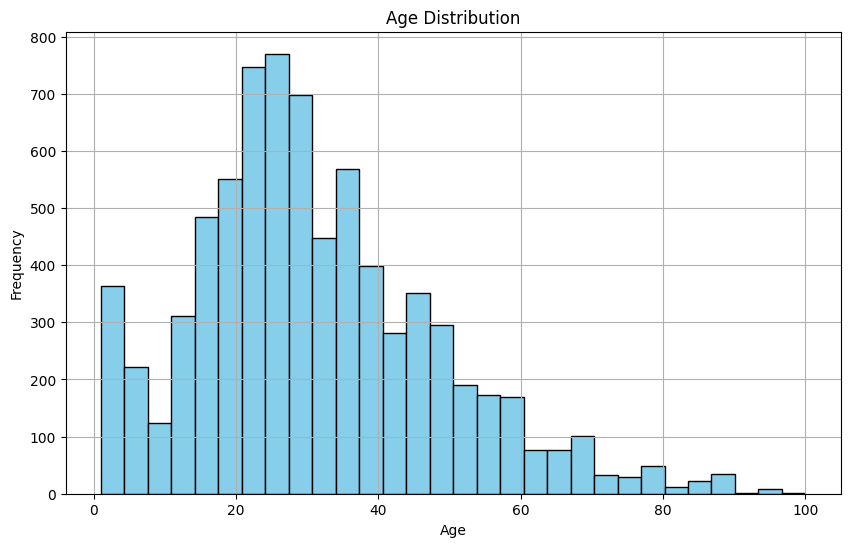

In [29]:
# Plot the distribution of ages
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Findings

**Right-skewed Distribution**:

- The data is heavily concentrated on the younger ages, with the frequency peaking around ages 15-25.
- There is a long tail extending to higher ages, indicating *fewer* individuals in the older age groups.

**Peak Age Group**:

- The highest frequency of individuals seems to be in the age range of approximately 15 to 30 years, suggesting a young population.

**Gradual Decline**:

- There is a consistent decline in the frequency of individuals as the age increases beyond 30.

**Outliers**:

- There are very few individuals aged 70 and above, which might indicate outliers or a natural cutoff in the dataset.

#### Output 10 Images

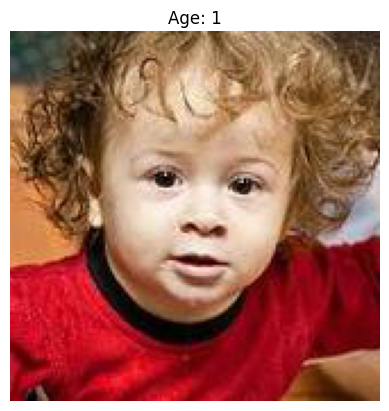

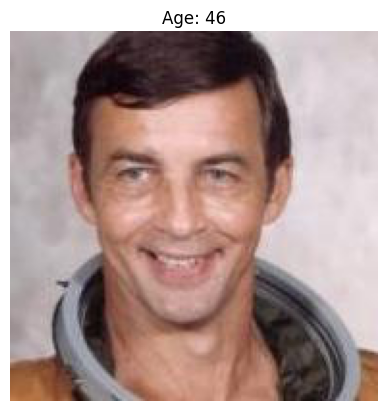

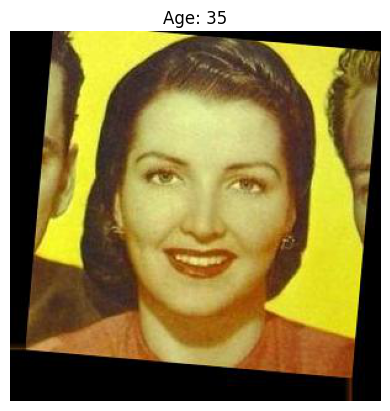

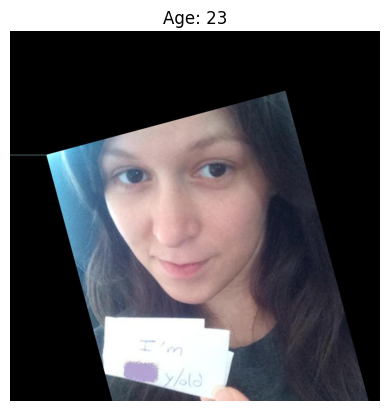

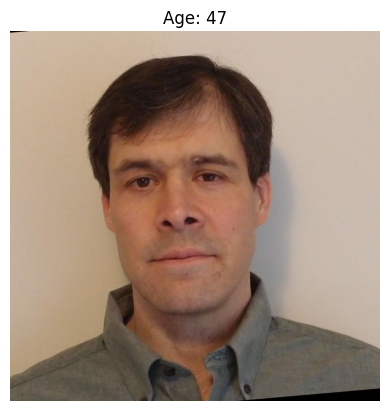

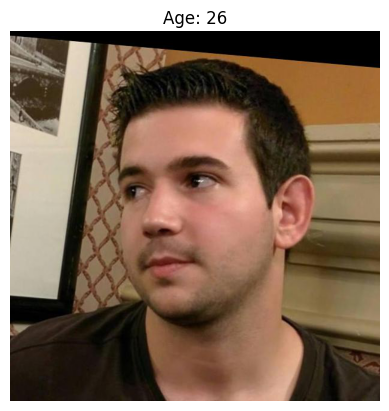

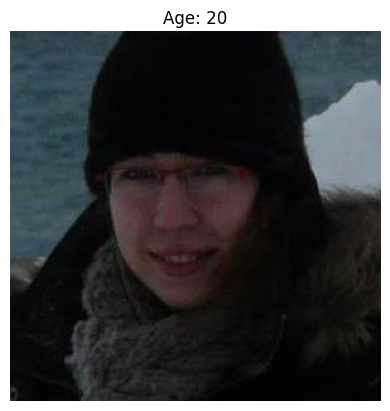

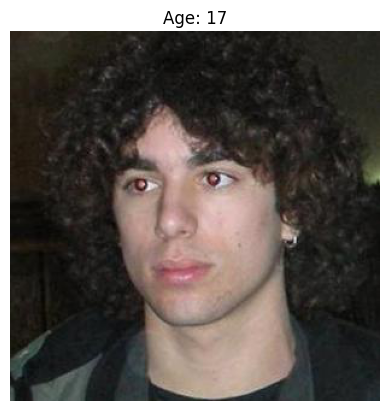

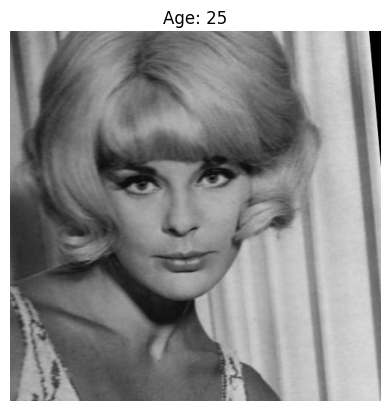

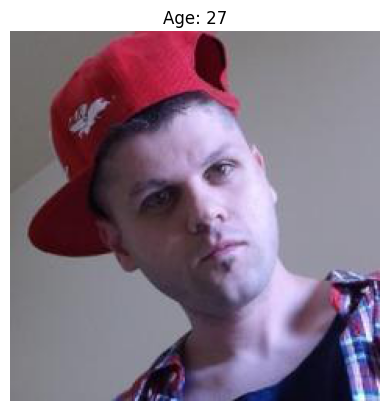

In [30]:
# Sample 10 random rows
sampled_data = labels.sample(10, random_state=42)

# Display images with their corresponding ages
for _, row in sampled_data.iterrows():
    img_path = os.path.join(image_folder, row['file_name'])
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Age: {row['real_age']}")
    plt.axis('off')
    plt.show()

`Sample Analysis`

- The ages span from early childhood (1 year old) to middle aged (47 years old).
- There is a mix of age groups, which lends itself well to capturing diversity in age related changes.
- The individuals appear to represent various genders and styles, also suggesting diversity in terms of appearance.
- The image quality varies, with some photos being sharper and more recent while others appear to be older or scanned from physical photographs.



## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [31]:
# Ensure GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TF to only the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
        
        # Enable memory growth 
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled memory growth for GPUs.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

Num GPUs Available:  0
No GPU detected. Running on CPU.


In [32]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    # place your code here
    labels = pd.read_csv(f'{path}/labels.csv')
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=373737
    )
    
    return train_gen_flow

In [33]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    # place your code here
    labels = pd.read_csv(f'{path}/labels.csv')
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=373737
    )
    
    return test_gen_flow

In [34]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    # place your code here
    base_model = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))  # 50% dropout rate
    model.add(Dense(1, activation='relu', kernel_regularizer=l2(0.001))) # L2 Regularization
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

In [35]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    # place your code here
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [36]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

## Conclusions

**Training and Validation Metrics**

- **Training loss and MAE**:

    - Loss: decreases from 95.35 to 17.02
    - MAE: decreases from 7.43 to 3.17

- **Validation loss and MAE**:

    - Loss: starts at 124.34, fluctuates, and ends at 93.41
    - MAE: starts at 8.49, decreases to around 6.64, but increases to 7.65 at the end

**Observations**
- Training metrics improve consistently:

    - The training loss and MAE decrease steadily over the epochs indicating that the model is learning patterns from the training data effectively.

- Validation metrics fluctuate:
    - Validation loss and MAE are not decreasing consistently.
    - Significant fluctuation in validation loss and MAE, particularly:
        - Epoch #12: A spike in validation loss to 185.63 and MAE to 11.46.
        - Post epoch #12:** Validation metrics improve slightly but do not reach significantly lower values.

**Gap between training and validation Metrics**:

- By the end of training:
    - Training MAE: ~3.17
    - Validation MAE: ~7.65
    
- *This noticeable gap suggests that the model performs significantly better on training data than on validation data*.


**Model overfitting**:
- Training metrics improve continuously, while validation metrics do not show proportional improvement. This widening gap between training and validation MAE shows that there is overfitting.
- The spike in validation loss and MAE at Epoch #12 suggests the model started to memorize the training data rather than learning generalizable patterns.

**Insufficient generalization**:
- The model may not be learning features that generalize well to the validation set. Possibly due to:
    - Inadequate Regularization or
    - Lack of/insufficient data augmentation (reduces diversity of training data).